## Import

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import ipyparallel as ipp
import matplotlib.pyplot as plt
import folium 
import requests
import json
import time
import pyomo.environ as pyo
from pyomo.environ import *

## Utils

### Car distance

#### Single pair

In [2]:
def car_distance(x,y):
    
    lon_1, lat_1 = x
    lon_2, lat_2 = y

    #print(f'x:\n{x}\ny:\n{y}\n')
    
    # call the OSMR API
    r = requests.get(f"http://router.project-osrm.org/route/v1/car/{lon_1},{lat_1};{lon_2},{lat_2}?overview=false""")
    # then you load the response using the json libray
    # by default you get only one alternative so you access 0-th element of the `routes`
    routes = json.loads(r.content)
    route_1 = routes.get("routes")[0]

    return route_1['distance']

car_distance = np.vectorize(car_distance, signature='(n),(n)->()')

#### Multiple pairs

In [109]:
def car_distances(coordinates, mode="all-vs-all", n=0, m=0):
        
    # define the first part of the URL (common for all modes)
    fix_url = "http://router.project-osrm.org/table/v1/car/"
    coordinates_url = "".join(["".join(str(str([i[0],i[1]]))[1:-1].split())+";" for i in coordinates])[:-1]
    
    # define the number of coordinates
    n = len(coordinates)
    
    if n <= 100:
        
        # if mode is "all-vs-all" all the coordinates are used as sources and destinations
        if mode == "all-vs-all": 
            r = requests.get(fix_url+coordinates_url+"?annotations=distance")
            
        # if mode is "n-vs-all" the first n coordinates are used as sources and all the coordinates are used as destinations
        elif mode == "n-vs-all":
            r = requests.get(fix_url+coordinates_url+"?annotations=distance&sources="+';'.join(str(i) for i in list(range(n+1))))
            
        # if mode is "n-vs-m" the first n coordinates are used as sources and the last m coordinates are used as destinations
        elif mode == "n-vs-m":
            r = requests.get(fix_url+coordinates_url+"?annotations=distance&sources="+';'.join(str(i) for i in list(range(n+1)))+"&destinations="+';'.join(str(len(coordinates)-i-1) for i in list(range(m+1))))
        
        # load the response using the json libray
        routes = json.loads(r.content)
        distances = np.array(routes["distances"])
    
    else:
        if mode == "all-vs-all": 
            distances = np.zeros((n,n))
            chunks = n//100
            
            # split the coordinates in chunks of 100
            for i in range(chunks):
                if i < chunks-1:
                    source_indexes = list(range(0+100*i,100+100*i))
                else:
                    source_indexes = list(range(0+100*i,n))
                
                # define the sources URL
                sources_url = "sources="+";".join(str(k) for k in source_indexes)
                
                
                for j in range(chunks):
                    if j < chunks-1:
                        destination_indexes = list(range(0+100*j,100+100*j))
                    else:
                        destination_indexes = list(range(0+100*j,n))
                    
                    # define the destinations URL
                    destinations_url = "destinations="+";".join(str(k) for k in destination_indexes)

                    # call the OSMR API
                    r = requests.get(fix_url+coordinates_url+"?annotations=distance&"+sources_url+"&"+destinations_url)
                    routes = json.loads(r.content)
                    
                    distances[0+100*i:100+100*i, 0+100*j:100+100*j] = np.array(routes["distances"])
    
    return distances

### Gon algorithm

In [5]:
# define the function to calculate the distance matrix
def max_dist_point(V, C, distance_matrix):
    
    min_point_dist = distance_matrix[:, C].min(axis=1)
    max_index = min_point_dist.argmax()
            
    return max_index

In [6]:
def global_iteration(C, V, distance_matrix, k):
    for i in range(k-1):
        # find the point in V that is the farthest from the set C
        # print time for each iteration to see the progress of the algorithm 
        max_index = max_dist_point(V, C, distance_matrix)
        C.append(max_index)
        
    max_index = max_dist_point(V, C, distance_matrix)
        
    return distance_matrix[max_index, C].min()

In [145]:
def gon(k, V: list, distance_matrix, mode="standard", n_trial=None):
    
    np.random.seed(1783297)
    
    # if mode is "standard" the algorithm is executed once
    if mode == "standard":
        C = []
        
        # choose a random point from V as the first centroid
        init = np.random.randint(0, len(V))
        C.append(init)
        
        t1 = time.time()
        opt_distance = global_iteration(C, V, distance_matrix, k)
        t2 = time.time()
        
        print(f'completed in {t2-t1} seconds')
    
    # if mode is "plus" the algorithm is executed n_trial times and the best result is returned
    elif mode == "plus" and n_trial > 0  and n_trial <= len(V) :
        C_l = []
        d = []
        
        # choose n_trial random points from V as the first centroids
        init = np.random.randint(0, len(V), n_trial)
        
        for i in range(n_trial):
            C_l.append([])
            C_l[i].append(init[i])

            t1 = time.time() 
            d.append(global_iteration(C_l[i], V, distance_matrix, k))
            t2 = time.time()
            
            print(f'iteration {i+1} of {n_trial} completed in {t2-t1} seconds')
        
        opt_distance = np.min(d)
        C = C_l[np.argmin(d)]
        
    else:
        return "invalid init"
    
    return C, opt_distance

## Data preparation (OPMS API)

### Shapefile reading

In [6]:
# Set filepath
# fp = "/workspaces/codespaces-jupyter/data/North California/gis_osm_transport_free_1.shp"
fp = 'data/North California/gis_osm_transport_free_1.shp'
transport_locations = gpd.read_file(fp)

In [7]:
# Set filepath
# fp = "/workspaces/codespaces-jupyter/data/County of Santa Clara/geo_export_742a7eac-9364-4734-a083-fd8f554cf8ca.shp"
fp = "data/County of Santa Clara/geo_export_742a7eac-9364-4734-a083-fd8f554cf8ca.shp"
santa_clara_county_boundaries = gpd.read_file(fp)

### Data exploration

In [8]:
type(transport_locations)

geopandas.geodataframe.GeoDataFrame

In [9]:
print(transport_locations.crs)

EPSG:4326


In [10]:
transport_locations.head(10)

,osm_id,code,fclass,name,geometry
0,30236493,5601,railway_station,San Antonio,POINT (-122.10724 37.40741)
1,30236612,5601,railway_station,Mountain View,POINT (-122.07588 37.39434)
2,53023702,5601,railway_station,Rockridge,POINT (-122.25126 37.84476)
3,57792672,5601,railway_station,Concord,POINT (-122.02907 37.97378)
4,57810647,5601,railway_station,Richmond,POINT (-122.35360 37.93687)
5,62538047,5602,railway_halt,Pantano,POINT (-121.88384 38.13803)
6,87362056,5602,railway_halt,Latrobe,POINT (-120.98695 38.56290)
7,90138751,5621,bus_stop,NaN,POINT (-121.31281 38.77474)
8,90408338,5602,railway_halt,Hampton,POINT (-121.11106 38.64463)
9,95327721,5601,railway_station,Ashby,POINT (-122.26971 37.85298)


In [15]:
print("BEFORE:", santa_clara_county_boundaries.crs)

santa_clara_county_boundaries = santa_clara_county_boundaries.to_crs(epsg= 4326)

print("AFTER:", santa_clara_county_boundaries.crs)

BEFORE: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
AFTER: EPSG:4326


In [16]:
santa_clara_county_boundaries

,acres,objectid,shape_area,shape_leng,sq_miles,y,geometry
0,835109.926034,2.0,3.637739e+10,1.132440e+06,1304.85926,Y,"POLYGON ((-121.74467 37.48386, -121.70037 37.4..."


<Axes: >

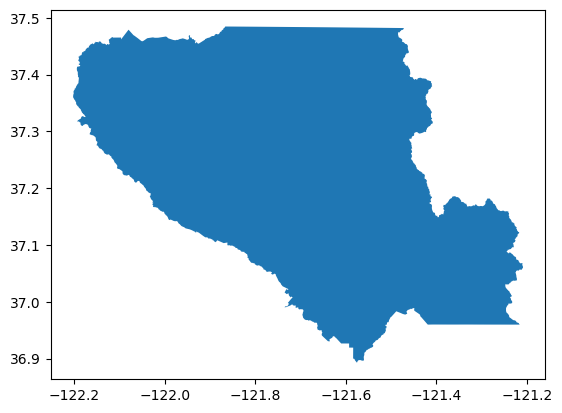

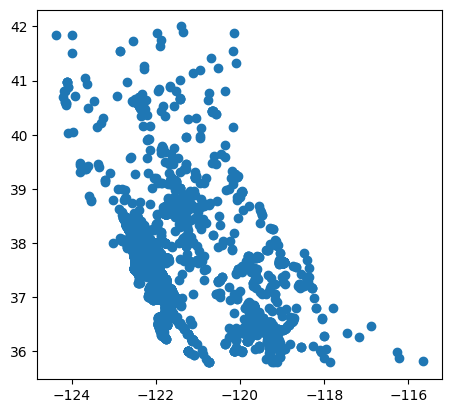

In [18]:
santa_clara_county_boundaries.plot()
transport_locations.plot()

### Santa clara data extraction

In [19]:
# take transport location within santa clara county boundaries
%time transport_location_is_in_santa_clara = transport_locations.apply(lambda x: gpd.GeoSeries(x.geometry, crs=4326).within(santa_clara_county_boundaries), axis=1)

CPU times: total: 37.1 s
Wall time: 1min 11s


In [20]:
transport_locations['transport_location_is_in_santa_clara'] = transport_location_is_in_santa_clara

In [21]:
transport_location_is_in_santa_clara.value_counts()

False    17601
True      3619
Name: count, dtype: int64

In [22]:
santa_clara_transport_locations = transport_locations.where(transport_locations.transport_location_is_in_santa_clara == True) \
.dropna() \
.drop(labels='transport_location_is_in_santa_clara', axis=1)

In [23]:
santa_clara_transport_locations

,osm_id,code,fclass,name,geometry
0,30236493,5601.0,railway_station,San Antonio,POINT (-122.10724 37.40741)
1,30236612,5601.0,railway_station,Mountain View,POINT (-122.07588 37.39434)
16,266800225,5621.0,bus_stop,El Camino Real & East Remington Drive,POINT (-122.02439 37.36102)
18,266910711,5601.0,railway_station,Capitol,POINT (-121.84176 37.28397)
19,266944543,5601.0,railway_station,Morgan Hill,POINT (-121.65053 37.12970)
...,...,...,...,...,...
20503,9632354205,5621.0,bus_stop,Bus Stop #2,POINT (-121.92957 37.37230)
20504,9632354206,5621.0,bus_stop,Bus Stop #3,POINT (-121.92775 37.37190)
20505,9632354207,5621.0,bus_stop,Bus Stop #4,POINT (-121.92854 37.37317)
20506,9632354208,5621.0,bus_stop,Bus Stop #5,POINT (-121.92973 37.37373)


### Save santa clara data

In [43]:
santa_clara_transport_locations.to_file("data/County of Santa Clara/santa_clara_transport_free.geojson", driver='GeoJSON')

## Read santa clara data

In [8]:
santa_clara_transport_locations = gpd.read_file("data/County of Santa Clara/santa_clara_transport_free.geojson")

In [9]:
santa_clara_transport_locations.fclass.unique()

array(['railway_station', 'bus_stop', 'bus_station', 'helipad',
       'railway_halt', 'taxi'], dtype=object)

### Data exploration

In [10]:
santa_clara_transport_locations.drop(['osm_id',	'code'], axis=1).describe(include='all')

,fclass,name,geometry
count,3577,3577,3577
unique,6,2524,3549
top,bus_stop,San Jose Diridon Transit Center,POINT (-121.9526847 37.409416)
freq,3441,10,2


In [11]:
santa_clara_transport_locations.name.value_counts()

name
San Jose Diridon Transit Center         10
Santa Clara Transit Center              10
Milpitas Transit Center                  9
Showers Drive & Latham Street            8
Alum Rock Transit Center                 8
                                        ..
Harry Road & Grandwood Way               1
McKean Road & Martwood Way               1
McKean Road & Almaden Road               1
Almaden Road & Mountain Shadows Road     1
Bus Stop #6                              1
Name: count, Length: 2524, dtype: int64

In [12]:
santa_clara_transport_locations.fclass.value_counts()

fclass
bus_stop           3441
railway_station      77
bus_station          48
taxi                  6
helipad               3
railway_halt          2
Name: count, dtype: int64

### Data visualization

In [7]:
n = len(santa_clara_transport_locations.fclass.unique())
n

6

In [8]:
# get a colormap with n colors
cmap = ['green', 'gray', 'red', 'orange', 'olive', 'blue']#, 'pink', 'brown', 'gray', 'olive', 'cyan'']

# map colors to fclass
colors = {fclass: cmap[i] for i, fclass in enumerate(santa_clara_transport_locations.fclass.unique())}

# print colors
print(colors)

{'railway_station': 'green', 'bus_stop': 'gray', 'bus_station': 'red', 'helipad': 'orange', 'railway_halt': 'olive', 'taxi': 'blue'}


In [9]:
# Create a geometry list from the GeoDataFrame
geo_df_list = [tuple([point[4].xy[1][0], point[4].xy[0][0], point[2]]) for point in santa_clara_transport_locations.values]

In [59]:
# OpenStreetMap
map_ = folium.Map(location=[37.335480, -121.893028], tiles="OpenStreetMap", zoom_start=10)
for point in range(len(santa_clara_transport_locations)):
    folium.Circle(geo_df_list[point][0:2], fill=True, color=colors[geo_df_list[point][2]]).add_to(map_)
map_

## P-center facility location solution

In [164]:
# Work on a sample of OPSM API data

demand_points = 300
candidate_locations = 3
santa_clara_transport_locations_sample = santa_clara_transport_locations\
                                            .where(santa_clara_transport_locations.fclass == "bus_stop")\
                                            .dropna()\
                                            .sample(demand_points, random_state=1783297)

In [165]:
santa_clara_transport_locations_sample.fclass.value_counts()

fclass
bus_stop    300
Name: count, dtype: int64

<Axes: >

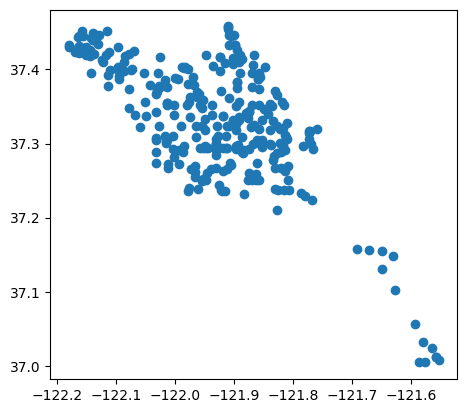

In [166]:
santa_clara_transport_locations_sample.plot()

In [167]:
# Create a geometry list from the GeoDataFrame
geo_df_list_sample = [[point.xy[0][0], point.xy[1][0]] for point in santa_clara_transport_locations_sample.geometry]

In [168]:
# OpenStreetMap
map_ = folium.Map(location=[37.335480, -121.893028], tiles="OpenStreetMap", zoom_start=10)
for point in range(len(santa_clara_transport_locations_sample)):
    folium.Circle([geo_df_list_sample[point][1],geo_df_list_sample[point][0]], radius = 200).add_to(map_)
map_

### Compute the distance matrix

In [170]:
%%time
distance_matrix = car_distances(geo_df_list_sample)

CPU times: total: 109 ms
Wall time: 48.6 s


### Exact solution 

In order to obtain the exact solution we model the problem as an LP problem

In [171]:
#-------------------------abastract model----------------------------
model = pyo.AbstractModel()

#---------------------------index sets-------------------------------
model.I = pyo.RangeSet(0, demand_points-1)
model.J = pyo.RangeSet(0, demand_points-1)

#---------------------------parameters-------------------------------
# define the number of locations to be opened (p)
model.p = pyo.Param(within = PositiveIntegers)

# define the distance matrix (d)
model.d = pyo.Param(model.I, model.J, within = NonNegativeReals)

#---------------------------variables--------------------------------
# define the binary variables for the location decision (x)
model.x = Var(model.J, within = Binary)

# define the binary variables for the assignment decision (y)
model.y = Var(model.I, model.J, within = Binary)

# define the auxiliary variable for the maximal distance (L)
model.L = Var(within = NonNegativeReals)

#--------------------------constraints-------------------------------
# define a constraint for each demand point to be covered by a single location
def completeSingleCoverage(model, i):
    return sum(model.y[i, j] for j in model.J) == 1

# define a constraint for the maximum number of locations
def maximumLocations(model):
    return sum([model.x[j] for j in model.J])  == pyo.value(model.p)

# define a constraint for the maximal distance (L is an auxiliary variable)
def maximalDistance(model, i):
    return sum(model.d[i, j] * model.y[i, j] for j in model.J) <= model.L

# define a constraint for each demand point to be served by an open facility
def servedByOpenFacility(model, i, j):
    return model.y[i, j] <= model.x[j]

model.completeSingleCoverage = Constraint(model.I, rule = completeSingleCoverage)
model.maximumLocations = Constraint(rule = maximumLocations)
model.maximalDistance = Constraint(model.I, rule = maximalDistance)
model.servedByOpenFacility = Constraint(model.I, model.J, rule = servedByOpenFacility)

#-----------------------objective function---------------------------
def maximalDistanceObj(model):
    return model.L

model.maximalDistanceObj = Objective(rule = maximalDistanceObj, sense = minimize)

#### Data initialization

In [172]:
d = {(i, j): distance_matrix[i][j] for i in range(demand_points) for j in range(demand_points)}

In [173]:
data = {None: {
    'p': {None: candidate_locations}, 
    'd': d
}
}

#### Instantiate the model

In [174]:
istance = model.create_instance(data)

#### Solve the model

In [175]:
%%time
opt = SolverFactory('cplex')
result = opt.solve(istance)

CPU times: total: 5.64 s
Wall time: 7min 22s


In [189]:
# Check the status of the solver
if result.solver.status == pyo.SolverStatus.ok and result.solver.termination_condition == pyo.TerminationCondition.optimal:
    print('Optimal solution found')
elif result.solver.termination_condition == pyo.TerminationCondition.infeasible:
    print('Problem is infeasible')
else:
    print('Solver terminated with status %s' % result.solver.termination_condition)

Optimal solution found


#### Results

In [190]:
for v in istance.component_data_objects(Objective):
    maximal_distance = pyo.value(v)

maximal_distance

18884.1

In [191]:
exact_solution_locations_index = []

for v in istance.component_data_objects(Var):
    if v.value == 1:
        if v.name[0] == 'x':
            exact_solution_locations_index.append(v.index())

exact_solution_locations = [geo_df_list_sample[i] for i in exact_solution_locations_index]

In [192]:
exact_solution_locations

[[-121.9058644, 37.2711086],
 [-121.6270996, 37.1023917],
 [-122.0290521, 37.3953197]]

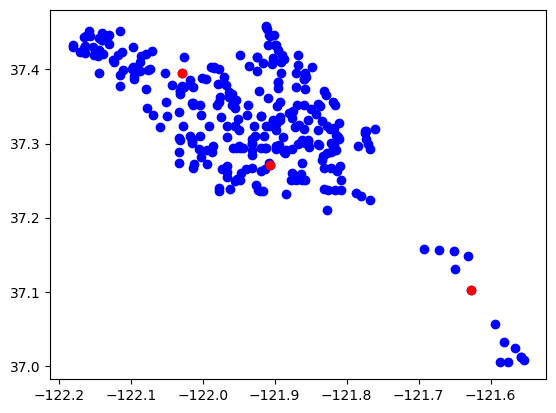

In [193]:
plt.scatter([x for x in np.array(geo_df_list_sample)[:,0]], [x for x in np.array(geo_df_list_sample)[:,1]], c = 'blue')
plt.scatter([x for x in np.array(exact_solution_locations)[:,0]], [x for x in np.array(exact_solution_locations)[:,1]], c = 'red')

### Simple Gon

In [194]:
%%time
C, d  = gon(candidate_locations, geo_df_list_sample, distance_matrix)

completed in 0.0 seconds
CPU times: total: 0 ns
Wall time: 996 µs


In [195]:
C, d

([202, 183, 108], 31516.9)

In [196]:
solution_locations = [geo_df_list_sample[i] for i in C]
solution_locations

[[-121.9485636, 37.2941131],
 [-121.5866478, 37.0050502],
 [-122.1645613, 37.4431724]]

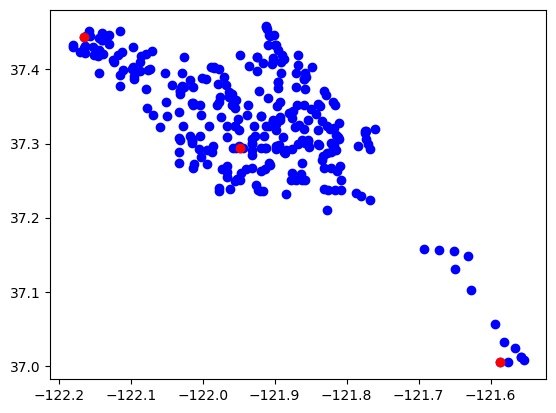

In [197]:
plt.scatter([x for x in np.array(geo_df_list_sample)[:,0]], [x for x in np.array(geo_df_list_sample)[:,1]], c = 'blue')
plt.scatter([x for x in np.array(solution_locations)[:,0]], [x for x in np.array(solution_locations)[:,1]], c = 'red')

### Gon+

In [201]:
%%time
C_plus, d_plus = gon(candidate_locations, geo_df_list_sample, distance_matrix, mode="plus", n_trial=demand_points)

iteration 1 of 300 completed in 0.0010390281677246094 seconds
iteration 2 of 300 completed in 0.0 seconds
iteration 3 of 300 completed in 0.0 seconds
iteration 4 of 300 completed in 0.0 seconds
iteration 5 of 300 completed in 0.0 seconds
iteration 6 of 300 completed in 0.0009613037109375 seconds
iteration 7 of 300 completed in 0.0 seconds
iteration 8 of 300 completed in 0.0 seconds
iteration 9 of 300 completed in 0.0 seconds
iteration 10 of 300 completed in 0.0 seconds
iteration 11 of 300 completed in 0.0 seconds
iteration 12 of 300 completed in 0.0 seconds
iteration 13 of 300 completed in 0.0 seconds
iteration 14 of 300 completed in 0.0 seconds
iteration 15 of 300 completed in 0.0 seconds
iteration 16 of 300 completed in 0.0 seconds
iteration 17 of 300 completed in 0.0 seconds
iteration 18 of 300 completed in 0.0 seconds
iteration 19 of 300 completed in 0.0 seconds
iteration 20 of 300 completed in 0.0 seconds
iteration 21 of 300 completed in 0.0 seconds
iteration 22 of 300 completed i

In [202]:
C_plus, d_plus

([253, 183, 84], 20306.2)

In [203]:
solution_locations = [geo_df_list_sample[i] for i in C_plus]
solution_locations

[[-122.0136029, 37.3756475],
 [-121.5866478, 37.0050502],
 [-121.7676978, 37.223973]]

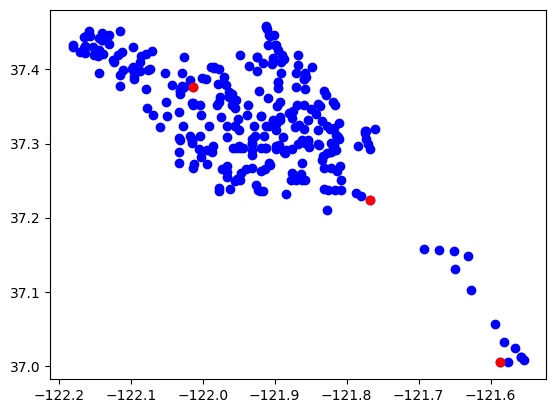

In [204]:
plt.scatter([x for x in np.array(geo_df_list_sample)[:,0]], [x for x in np.array(geo_df_list_sample)[:,1]], c = 'blue')
plt.scatter([x for x in np.array(solution_locations)[:,0]], [x for x in np.array(solution_locations)[:,1]], c = 'red')

# End